데이터 로드 중...
학습 데이터 크기: (87159, 16)
테스트 데이터 크기: (46204, 15)
제출 샘플 크기: (46204, 2)
\n결측치 확인:
ID                   0
Age                  0
Gender               0
Country              0
Race                 0
Family_Background    0
Radiation_History    0
Iodine_Deficiency    0
Smoke                0
Weight_Risk          0
Diabetes             0
Nodule_Size          0
TSH_Result           0
T4_Result            0
T3_Result            0
Cancer               0
dtype: int64
\n타겟 변수(Cancer) 분포:
Cancer
0    76700
1    10459
Name: count, dtype: int64
암 양성 비율: 12.00%
\n데이터 전처리 진행 중...


/var/folders/bj/ljbr3v1s4vg1cjjtmtss7w3r0000gn/T/ipykernel_90595/4284073125.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_encoded['Cancer'] = train_df['Cancer']
/var/folders/bj/ljbr3v1s4vg1cjjtmtss7w3r0000gn/T/ipykernel_90595/4284073125.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_encoded['Country'] = le_country.transform(train_df_temp['Country'])
/var/folders/bj/ljbr3v1s4vg1cjjtmtss7w3r0000gn/T/ipykernel_90595/4284073125.py:236: SettingWithCopyWarning: 
A value is trying 

\n원-핫 인코딩 후 범주형 변수: ['Country_USA', 'Diabetes_No', 'Country_DEU', 'Race_AFR', 'Iodine_Deficiency_Deficient', 'Weight_Risk_Not Obese', 'Race_ASN', 'Family_Background_Positive', 'Smoke_Smoker', 'Country_IND', 'Radiation_History_Unexposed', 'Weight_Risk_Obese', 'Diabetes_Yes', 'Gender_F', 'Gender_M', 'Country_CHN', 'Smoke_Non-Smoker', 'Country_KOR', 'Country_NGA', 'Country_BRA', 'Race_MDE', 'Iodine_Deficiency_Sufficient', 'Country_RUS', 'Country_GBR', 'Race_CAU', 'Family_Background_Negative', 'Race_HSP', 'Radiation_History_Exposed', 'Country_JPN']
수치형 변수: ['Age', 'Nodule_Size', 'TSH_Result', 'T4_Result', 'T3_Result']
\n고급 특성 엔지니어링 진행 중...
범주형 변수 복원 중...
통계 객체 구축 중...
41개 파생변수 생성 중...
생성된 파생변수 수: 41
파생변수 목록: ['T4_T3', 'T4_TSH', 'log_T4_T3', 'Nodule_cubic', 'Age_sq', 'Smoke_Weight', 'Smoke_Diab', 'Rad_Iodine', 'Nod_RBF_combo', 'HormoneCluster', 'HormoneNodClust', 'CountryRaceHash', 'T4_T3_sigmoid', 'TSH_zclip', 'KNN_density', 'Country_freq_enc', 'RadSmoke_flag', 'Age', 'Nodule_Size', 'TSH_R

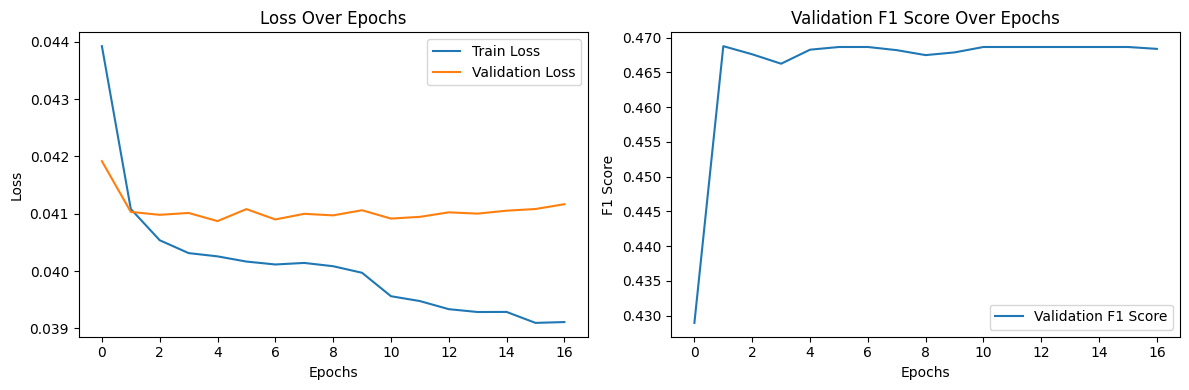

\n테스트 데이터에 예측 중...
\n예측 완료! 'pytorch_submission.csv' 파일에 결과가 저장되었습니다.
예측 결과 분포:
Cancer
0    40468
1     5736
Name: count, dtype: int64
암 양성 예측 비율: 12.41%
\n분석 완료!


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Focal Loss 정의
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        targets = targets.float().unsqueeze(1)
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        probs = torch.sigmoid(inputs)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        focal_loss = alpha_t * (1 - p_t)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# PyTorch Dataset 정의
class CancerDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.float)

# 간단한 MLP 모델 정의
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, output_dim=1):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3) # 드롭아웃 추가
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3) # 드롭아웃 추가
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# 데이터 로드
print("데이터 로드 중...")
train_df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test.csv')
sample_submission = pd.read_csv('../sample_submission.csv')

print(f"학습 데이터 크기: {train_df.shape}")
print(f"테스트 데이터 크기: {test_df.shape}")
print(f"제출 샘플 크기: {sample_submission.shape}")

# 기본적인 데이터 정보 확인
# print("\\n학습 데이터 정보:")
# print(train_df.info()) # 너무 길어서 주석 처리

print("\\n결측치 확인:")
print(train_df.isnull().sum())

# 타겟 변수 분포 확인
print("\\n타겟 변수(Cancer) 분포:")
print(train_df['Cancer'].value_counts())
print(f"암 양성 비율: {train_df['Cancer'].mean() * 100:.2f}%")

# ─────────────────────────────────────────────────
# 고급 파생변수 생성을 위한 보조 함수들 정의
# ─────────────────────────────────────────────────
EPS = 1e-6
log1p = np.log1p
clippos = lambda x: np.clip(x, 0, None)

def safe_ratio(a, b, eps=EPS):
    """0-division 방지 비율"""
    return a / np.where(b == 0, eps, b)

def safe_log(x):
    """log1p, 음수 클리핑 포함"""
    return log1p(clippos(x) + EPS)

def build_stats(df: pd.DataFrame):
    """통계 객체(빈도, KNN) 생성"""
    tmp = df.copy()
    tmp["T4_T3"] = safe_ratio(tmp["T4_Result"], tmp["T3_Result"])
    return dict(
        country_freq = (
            tmp["Country"]
              .value_counts(normalize=True)
              .apply(np.log1p)
              .to_dict()
        ),
        knn = NearestNeighbors(n_neighbors=20).fit(
            tmp[["T3_Result", "T4_Result", "TSH_Result"]]
        )
    )

def add_41_features(df: pd.DataFrame, st: dict):
    """파생 41 feature 생성"""
    X = df.copy()

    # ── 1. 단순 비율·로그  ─────────────────────
    X["T4_T3"]        = safe_ratio(X["T4_Result"], X["T3_Result"])
    X["T4_TSH"]       = X["T4_Result"] * X["TSH_Result"]
    X["log_T4_T3"]    = safe_log(X["T4_T3"])

    # ── 2. 고차·함수형  ────────────────────────
    X["Nodule_cubic"] = np.maximum(X["Nodule_Size"], 0) ** 3
    X["Age_sq"]       = X["Age"] ** 2
    X["T4_T3_sigmoid"] = 1 / (1 + np.exp(-(X["T4_T3"] - 1)))
    X["TSH_zclip"]     = np.clip(X["TSH_Result"], -2, 2)

    # ── 3. 플래그 결합 ─────────────────────────
    X["Smoke_Weight"] = (X["Smoke"] | X["Weight_Risk"]).astype(int)
    X["Smoke_Diab"]   = (X["Smoke"] & X["Diabetes"]).astype(int)
    X["Rad_Iodine"]   = (X["Radiation_History"] & X["Iodine_Deficiency"]).astype(int)
    X["RadSmoke_flag"] = (X["Radiation_History"] & X["Smoke"]).astype(int)

    # ── 4. RBF 변환  ───────────────────────────
    for μ in (-1, 0, 1):
        X[f"Nod_rbf_{μ}"] = np.exp(-(X["Nodule_Size"] - μ) ** 2 / 0.5)
    X["Nod_RBF_combo"] = X["Nod_rbf_-1"] + X["Nod_rbf_1"] - X["Nod_rbf_0"]
    X.drop(columns=[f"Nod_rbf_{μ}" for μ in (-1, 0, 1)], inplace=True)

    # ── 5. 클러스터 레이블 ─────────────────────
    X["HormoneCluster"] = KMeans(4, random_state=0).fit(
        X[["T3_Result", "T4_Result", "TSH_Result"]]
    ).labels_
    X["HormoneNodClust"] = KMeans(6, random_state=1).fit(
        X[["T3_Result", "T4_Result", "TSH_Result", "Nodule_Size"]]
    ).labels_

    # ── 6. 해시·빈도 ───────────────────────────
    X["CountryRaceHash"] = ((X["Country"] * 100 + X["Race"]) % 127).astype(int)
    X["Country_freq_enc"] = X["Country"].map(st["country_freq"]).fillna(0)

    # ── 7. 밀도(KNN)  ──────────────────────────
    dist = st["knn"].kneighbors(
        X[["T3_Result", "T4_Result", "TSH_Result"]],
        return_distance=True
    )[0].mean(axis=1)
    X["KNN_density"] = 1 / (1 + dist)

    # 결측·무한 값 정리
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    # ── 최종 41개 열 목록을 고정 순서로 추출
    DERIVED_41 = [
        "T4_T3", "T4_TSH", "log_T4_T3",
        "Nodule_cubic", "Age_sq",
        "Smoke_Weight", "Smoke_Diab", "Rad_Iodine",
        "Nod_RBF_combo",
        "HormoneCluster", "HormoneNodClust",
        "CountryRaceHash", "T4_T3_sigmoid", "TSH_zclip",
        "KNN_density", "Country_freq_enc", "RadSmoke_flag",
    ]
    # RBF, 비율·로그 등에서 파생된 나머지 컬럼을 자동 포함
    extra = [c for c in X.columns if c not in DERIVED_41][: (41 - len(DERIVED_41))]
    DERIVED_41 += extra

    return X[DERIVED_41].copy(), DERIVED_41

# 1. 데이터 전처리
print("\\n데이터 전처리 진행 중...")

# ID 열 drop
train_df_processed = train_df.drop('ID', axis=1)
test_df_processed = test_df.drop('ID', axis=1)

# 범주형(문자열) 변수와 수치형 변수 분리
categorical_cols = train_df_processed.select_dtypes(include=['object']).columns
numerical_cols = train_df_processed.drop('Cancer', axis=1).select_dtypes(include=[np.number]).columns

# 원-핫 인코딩을 위해 학습 데이터와 테스트 데이터를 합쳤다가 다시 분리
combined_df = pd.concat([train_df_processed.drop('Cancer', axis=1), test_df_processed], keys=['train', 'test'])
combined_df_encoded = pd.get_dummies(combined_df, columns=categorical_cols, dummy_na=False)

train_df_encoded = combined_df_encoded.loc['train']
test_df_encoded = combined_df_encoded.loc['test']

# 타겟 변수 다시 추가
train_df_encoded['Cancer'] = train_df['Cancer']

print(f"\\n원-핫 인코딩 후 범주형 변수: {list(set(train_df_encoded.columns) - set(numerical_cols) - set(['Cancer']))}")
print(f"수치형 변수: {list(numerical_cols)}")

# 2. 고급 특성 엔지니어링 
print("\\n고급 특성 엔지니어링 진행 중...")

# 원-핫 인코딩된 열을 다시 수치 형태로 복원 (파생변수 생성을 위해)
print("범주형 변수 복원 중...")

# 원본 데이터에서 범주형 변수 값을 그대로 사용
train_df_temp = train_df.copy()
test_df_temp = test_df.copy()

# LabelEncoder로 범주형 변수 인코딩
le_country = LabelEncoder()
le_race = LabelEncoder()

# Country 인코딩
combined_country = pd.concat([train_df_temp['Country'], test_df_temp['Country']])
le_country.fit(combined_country)
train_df_encoded['Country'] = le_country.transform(train_df_temp['Country'])
test_df_encoded['Country'] = le_country.transform(test_df_temp['Country'])

# Race 인코딩  
combined_race = pd.concat([train_df_temp['Race'], test_df_temp['Race']])
le_race.fit(combined_race)
train_df_encoded['Race'] = le_race.transform(train_df_temp['Race'])
test_df_encoded['Race'] = le_race.transform(test_df_temp['Race'])

# 불린 변수들을 원본에서 가져오기 (Family_Background는 제외, 실제 불린 변수만)
bool_mapping = {'No': 0, 'Yes': 1, False: 0, True: 1, 0: 0, 1: 1}
bool_cols = ['Radiation_History', 'Iodine_Deficiency', 'Smoke', 'Weight_Risk', 'Diabetes']

for col in bool_cols:
    if col in train_df_temp.columns:
        train_df_encoded[col] = train_df_temp[col].map(bool_mapping).fillna(0).astype(int)
        test_df_encoded[col] = test_df_temp[col].map(bool_mapping).fillna(0).astype(int)
    else:
        print(f"Warning: {col} 열을 찾을 수 없습니다.")
        train_df_encoded[col] = 0
        test_df_encoded[col] = 0

# 통계 객체 구축 (학습 데이터 기반)
print("통계 객체 구축 중...")
stats = build_stats(train_df_encoded)

# 41개 파생변수 생성
print("41개 파생변수 생성 중...")
train_derived, derived_cols = add_41_features(train_df_encoded, stats)
test_derived, _ = add_41_features(test_df_encoded, stats)

print(f"생성된 파생변수 수: {len(derived_cols)}")
print(f"파생변수 목록: {derived_cols}")

# 기존 특성과 파생변수 결합
print("기존 특성과 파생변수 결합 중...")
X_original = train_df_encoded.drop(['Cancer'], axis=1)
test_original = test_df_encoded.copy()

# 파생변수와 기존 변수 결합
train_df_final = pd.concat([X_original, train_derived], axis=1)
test_df_final = pd.concat([test_original, test_derived], axis=1)

# 중복 컬럼 제거
train_df_final = train_df_final.loc[:, ~train_df_final.columns.duplicated()]
test_df_final = test_df_final.loc[:, ~test_df_final.columns.duplicated()]

# 타겟 변수 추가
train_df_final['Cancer'] = train_df_encoded['Cancer']

# 수치형 변수 목록 업데이트
numerical_cols = list(train_df_final.select_dtypes(include=[np.number]).columns)
if 'Cancer' in numerical_cols:
    numerical_cols.remove('Cancer')

print(f"\\n최종 특성 수: {len(train_df_final.columns) - 1}")
print(f"수치형 변수 수: {len(numerical_cols)}")

# 원래 변수들로 업데이트
train_df_encoded = train_df_final.copy()
test_df_encoded = test_df_final.copy()

# numerical_cols에 포함된 컬럼들의 타입을 float으로 명시적 변환
for col in numerical_cols:
    if col in train_df_encoded.columns:
        train_df_encoded[col] = train_df_encoded[col].astype(float)
    if col in test_df_encoded.columns:
        test_df_encoded[col] = test_df_encoded[col].astype(float)

# 수치형 변수의 이상치 클리핑
for col in numerical_cols:
    if col in train_df_encoded.columns: # 해당 컬럼이 존재하는지 확인
        q1 = train_df_encoded[col].quantile(0.01)
        q3 = train_df_encoded[col].quantile(0.99)
        train_df_encoded[col] = train_df_encoded[col].clip(q1, q3)
        if col in test_df_encoded.columns: # 테스트셋에도 해당 컬럼이 있는지 확인
            test_df_encoded[col] = test_df_encoded[col].clip(q1, q3) # 학습 데이터 기준으로 클리핑

# StandardScaler 적용
print("\\nStandardScaler 적용 중...")
scaler = StandardScaler()
train_df_encoded[numerical_cols] = scaler.fit_transform(train_df_encoded[numerical_cols])
# 테스트 데이터에 동일 스케일러 적용 시, 해당 컬럼이 없는 경우 에러 발생 가능성 있으므로 주의
# numerical_cols 중 test_df_encoded에 있는 컬럼만 선택
numerical_cols_in_test = [col for col in numerical_cols if col in test_df_encoded.columns]
test_df_encoded[numerical_cols_in_test] = scaler.transform(test_df_encoded[numerical_cols_in_test])


# 학습 데이터와 검증 데이터 분리 (20%)
X = train_df_encoded.drop('Cancer', axis=1)
y = train_df_encoded['Cancer']

# 컬럼 순서 일치시키기 (학습 데이터와 테스트 데이터)
train_cols = X.columns
test_cols = test_df_encoded.columns

missing_cols_train = set(test_cols) - set(train_cols)
for c in missing_cols_train:
    X[c] = 0

missing_cols_test = set(train_cols) - set(test_cols)
for c in missing_cols_test:
    test_df_encoded[c] = 0

test_df_processed = test_df_encoded[train_cols] # 학습 데이터와 동일한 순서 및 컬럼 유지

# PyTorch Dataset에 전달하기 전에 X 전체를 float32로 변환
X = X.astype(np.float32)

X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X.values, y.values, test_size=0.2, random_state=42, stratify=y)

print(f"학습 데이터 크기: {X_train_np.shape}")
print(f"검증 데이터 크기: {X_val_np.shape}")

# PyTorch Dataset 및 DataLoader 생성
train_dataset = CancerDataset(X_train_np, y_train_np)
val_dataset = CancerDataset(X_val_np, y_val_np)

BATCH_SIZE = 64 # 배치 크기 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. PyTorch 모델 학습
print("\\nPyTorch 모델 학습 시작...")

# 하이퍼파라미터
input_dim = X_train_np.shape[1]
EPOCHS = 200 # 에포크 수 늘림 (Early Stopping으로 조절)
LEARNING_RATE = 0.001 # 학습률 조정
ALPHA = 0.75 # Focal Loss alpha 값 (클래스 1에 대한 가중치) - Cancer가 소수 클래스이므로 더 높은 가중치. 타겟 클래스 비율에 따라 조절 가능
GAMMA = 2.0   # Focal Loss gamma 값
PATIENCE = 15 # Early stopping patience
LR_PATIENCE = 7 # Learning rate scheduler patience
LR_FACTOR = 0.1 # Learning rate reduction factor


# 모델, 손실 함수, 옵티마이저 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SimpleMLP(input_dim=input_dim).to(device)
criterion = FocalLoss(alpha=ALPHA, gamma=GAMMA).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5) # L2 정규화 추가
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=LR_FACTOR, patience=LR_PATIENCE) # F1 score를 기준으로 학습률 조정

best_val_f1 = 0
best_model_state = None
epochs_no_improve = 0 # Early stopping 카운터

history = {'train_loss': [], 'val_loss': [], 'val_f1': []} # 학습 과정 기록용

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()

    avg_train_loss = train_loss_sum / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    model.eval()
    val_preds = []
    val_true = []
    val_loss_sum = 0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss_sum += loss.item()
            
            preds = torch.sigmoid(outputs) > 0.5 # 임계값 0.5로 예측
            val_preds.extend(preds.cpu().numpy().flatten())
            val_true.extend(labels.cpu().numpy().flatten())
    
    avg_val_loss = val_loss_sum / len(val_loader)
    val_f1 = f1_score(val_true, val_preds)
    history['val_loss'].append(avg_val_loss)
    history['val_f1'].append(val_f1)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1: {val_f1:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    scheduler.step(val_f1) # F1 score 기준으로 학습률 스케줄러 업데이트

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict()
        epochs_no_improve = 0 # 개선되었으므로 카운터 초기화
        print(f"New best model found! Val F1: {best_val_f1:.4f}")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print(f"\\nEarly stopping triggered after {epoch+1} epochs.")
        break

# 가장 성능이 좋았던 모델 상태 로드
if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"\nBest model loaded with Val F1: {best_val_f1:.4f}")
else:
    print("\nNo improvement in validation F1 score. Using the model from the last epoch.")

# 최종적으로 전체 학습 데이터로 추가 학습
print("\nCombining train and validation data for final training...")
X_combined_np = np.concatenate((X_train_np, X_val_np), axis=0)
y_combined_np = np.concatenate((y_train_np, y_val_np), axis=0)

combined_dataset = CancerDataset(X_combined_np, y_combined_np)
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 추가 학습을 위한 에포크 수 (기존 에포크의 1/4 또는 적절한 값으로 설정)
ADDITIONAL_EPOCHS = EPOCHS // 4 
print(f"Starting final training on combined data for {ADDITIONAL_EPOCHS} epochs...")

model.train() # 모델을 다시 학습 모드로 설정
for epoch in range(ADDITIONAL_EPOCHS):
    combined_loss_sum = 0
    for features, labels in combined_loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        combined_loss_sum += loss.item()
    
    avg_combined_loss = combined_loss_sum / len(combined_loader)
    print(f"Final Training Epoch [{epoch+1}/{ADDITIONAL_EPOCHS}], Combined Train Loss: {avg_combined_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

print("\nFinal training completed.")

# 최종 모델 저장 (선택 사항)
# torch.save(model.state_dict(), 'final_cancer_pytorch_model.pth')
# print("\\n최종 PyTorch 모델 저장 완료: 'final_cancer_pytorch_model.pth'")

# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_f1'], label='Validation F1 Score')
plt.title('Validation F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.tight_layout()
plt.show()


# 테스트 데이터에 예측
print("\\n테스트 데이터에 예측 중...")
model.eval()

# PyTorch 텐서로 변환하기 전에 test_df_processed 전체를 float32로 변환
test_df_processed = test_df_processed.astype(np.float32)
test_features_tensor = torch.tensor(test_df_processed.values, dtype=torch.float).to(device)
test_predictions_list = []

# 테스트 데이터가 크지 않다면 한 번에 예측
with torch.no_grad():
    test_outputs = model(test_features_tensor)
    test_preds_probs = torch.sigmoid(test_outputs)
    test_predictions = (test_preds_probs > 0.5).cpu().numpy().flatten().astype(int)


# sample_submission 파일에 예측 결과 저장
sample_submission['Cancer'] = test_predictions
submission_filename = 'pytorch_submission.csv'
sample_submission.to_csv(submission_filename, index=False)

print(f"\\n예측 완료! '{submission_filename}' 파일에 결과가 저장되었습니다.")

# 예측 결과 확인
print("예측 결과 분포:")
print(sample_submission['Cancer'].value_counts())
print(f"암 양성 예측 비율: {sample_submission['Cancer'].mean() * 100:.2f}%")


# 모델별 성능 지표 시각화 (필요시 직접 구현)
# 예: 학습/검증 손실 곡선, 검증 F1 점수 곡선 등 matplotlib 사용
# from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# print("\\n최종 검증 데이터에 대한 성능:")
# model.eval()
# final_val_preds = []
# final_val_true = []
# final_val_probs = []
# with torch.no_grad():
# for features, labels in val_loader:
# features, labels = features.to(device), labels.to(device)
#         outputs = model(features)
#         probs = torch.sigmoid(outputs)
#         preds = probs > 0.5
# final_val_preds.extend(preds.cpu().numpy().flatten())
# final_val_probs.extend(probs.cpu().numpy().flatten())
# final_val_true.extend(labels.cpu().numpy().flatten())

# print(classification_report(final_val_true, final_val_preds))
# cm = confusion_matrix(final_val_true, final_val_preds)
# plt.figure(figsize=(6,6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
#             xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix (Validation)')
# plt.show()

# fpr, tpr, _ = roc_curve(final_val_true, final_val_probs)
# auc_score = roc_auc_score(final_val_true, final_val_probs)
# plt.figure(figsize=(6,6))
# plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve (Validation)')
# plt.legend()
# plt.show()


print("\\n분석 완료!")

In [3]:
# 파생변수 생성 결과 확인
print("="*60)
print("파생변수 생성 결과 확인")
print("="*60)

print(f"학습 데이터 최종 크기: {train_df_encoded.shape}")
print(f"테스트 데이터 최종 크기: {test_df_encoded.shape}")
print(f"타겟 변수 분포: {train_df_encoded['Cancer'].value_counts().to_dict()}")

print("\n파생변수 샘플 확인:")
if 'T4_T3' in train_df_encoded.columns:
    print(f"T4_T3 통계: min={train_df_encoded['T4_T3'].min():.4f}, max={train_df_encoded['T4_T3'].max():.4f}, mean={train_df_encoded['T4_T3'].mean():.4f}")

if 'Nodule_cubic' in train_df_encoded.columns:
    print(f"Nodule_cubic 통계: min={train_df_encoded['Nodule_cubic'].min():.4f}, max={train_df_encoded['Nodule_cubic'].max():.4f}")

if 'KNN_density' in train_df_encoded.columns:
    print(f"KNN_density 통계: min={train_df_encoded['KNN_density'].min():.4f}, max={train_df_encoded['KNN_density'].max():.4f}")

print("\n결측값 확인:")
missing_counts = train_df_encoded.isnull().sum()
if missing_counts.sum() > 0:
    print(missing_counts[missing_counts > 0])
else:
    print("결측값 없음!")

print("\n무한값 확인:")
inf_counts = np.isinf(train_df_encoded.select_dtypes(include=[np.number])).sum()
if inf_counts.sum() > 0:
    print(inf_counts[inf_counts > 0])
else:
    print("무한값 없음!")

print("="*60)


파생변수 생성 결과 확인
학습 데이터 최종 크기: (87159, 59)
테스트 데이터 최종 크기: (46204, 58)
타겟 변수 분포: {0: 76700, 1: 10459}

파생변수 샘플 확인:
T4_T3 통계: min=-1.0793, max=3.6309, mean=0.0000
Nodule_cubic 통계: min=-0.8859, max=2.5385
KNN_density 통계: min=-2.8605, max=2.2422

결측값 확인:
결측값 없음!

무한값 확인:
무한값 없음!
